In [1]:
!pip install -q transformers accelerate

In [2]:
!pip install -q librosa

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
import librosa
import torch
import matplotlib.pyplot as plt
import os

# canlinzhang/wav2vec2_speech_emotion_recognition_trained_on_IEMOCAP

In [ ]:
target_sampling_rate = 16000
model_name = 'canlinzhang/wav2vec2_speech_emotion_recognition_trained_on_IEMOCAP'

In [ ]:
audio_path = "/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script03_2_F041_Angry.wav"

In [ ]:
#build id and label dicts
id2label = {0:'Neutral', 1:'Angry', 2:'Sad', 3:'Happy'}
label2id = {'Neutral':0, 'Angry':1, 'Sad':2, 'Happy':3}

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [ ]:
model = AutoModelForAudioClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at canlinzhang/wav2vec2_speech_emotion_recognition_trained_on_IEMOCAP were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at canlinzhang/wav2vec2_speech_emotion_recognition_trained_on_IEMOCAP and are newly initialized: ['wav2vec2.encoder.pos_conv_embe

In [ ]:
y_waveform , sr = librosa.load(audio_path, sr=target_sampling_rate)

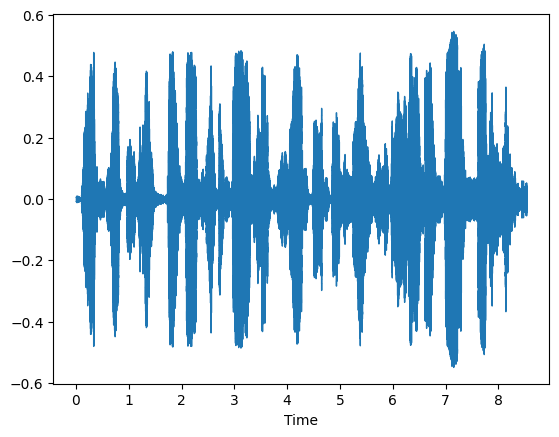

In [ ]:
librosa.display.waveshow(y_waveform, sr=sr)

In [ ]:
inputs = feature_extractor(y_waveform, sampling_rate=target_sampling_rate, return_tensors="pt")

In [ ]:
logits = model(**inputs).logits

In [ ]:
logits

tensor([[-1.8465,  6.9675, -1.3906, -1.6604]], grad_fn=<AddmmBackward0>)

In [ ]:
predicted_class_ids = torch.argmax(logits).item()

In [ ]:
pred_class = id2label[predicted_class_ids]

In [ ]:
print(pred_class)

Angry


In [ ]:
def get_emotion(audio_path,feature_extractor,model):
  target_sampling_rate = 16000
  y_waveform , sr = librosa.load(audio_path, sr=target_sampling_rate)
  inputs = feature_extractor(y_waveform, sampling_rate=target_sampling_rate, return_tensors="pt")
  logits = model(**inputs).logits
  predicted_class_ids = torch.argmax(logits).item()
  pred_class = id2label[predicted_class_ids]

  return pred_class

In [ ]:
file_path = [f"/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/{path}" for path in os.listdir("/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files")]
for path in file_path:
  emotions = get_emotion(path,feature_extractor,model)
  print(path,"--->",emotions)

/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Tom cruise angry dialouge.mp3 ---> Angry
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro02_M025_Sad.wav ---> Happy
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro03_M012_Happy.wav ---> Happy
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro04_F008_Neutral.wav ---> Neutral
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro08_M009_Neutral.wav ---> Neutral
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script01_1b_M005_Sad.wav ---> Sad
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script02_2_F005_Angry.wav ---> Angry
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script02_2_F034_Happy.wav ---> Neutral
/content/drive/MyDrive/Data Science /Sentiment From Audio/

# Hubert Finetuned Model - xmj2002/hubert-base-ch-speech-emotion-recognition

In [ ]:
import os
import random

import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoConfig, Wav2Vec2FeatureExtractor, HubertPreTrainedModel, HubertModel

In [ ]:
model_name_or_path = "xmj2002/hubert-base-ch-speech-emotion-recognition"
duration = 8
sample_rate = 16000

In [ ]:
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=model_name_or_path
)

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [ ]:
class HubertClassificationHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.classifier_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_class)

    def forward(self, x):
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [ ]:
class HubertForSpeechClassification(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.hubert = HubertModel(config)
        self.classifier = HubertClassificationHead(config)
        self.init_weights()

    def forward(self, x):
        outputs = self.hubert(x)
        hidden_states = outputs[0]
        x = torch.mean(hidden_states, dim=1)
        x = self.classifier(x)
        return x

In [ ]:
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = HubertForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at xmj2002/hubert-base-ch-speech-emotion-recognition were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at xmj2002/hubert-base-ch-speech-emotion-recognition and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encod

In [ ]:
def id2class(id):
    if id == 0:
        return "angry"
    elif id == 1:
        return "fear"
    elif id == 2:
        return "happy"
    elif id == 3:
        return "neutral"
    elif id == 4:
        return "sad"
    else:
        return "neutral"

In [ ]:
def predict(path, processor, model):
    speech, sr = librosa.load(path=path, sr=sample_rate)
    speech = processor(speech, padding="max_length", truncation=True, max_length=duration * sr,
                       return_tensors="pt", sampling_rate=sr).input_values
    with torch.no_grad():
        logit = model(speech)
    score = F.softmax(logit, dim=1).detach().cpu().numpy()[0]
    id = torch.argmax(logit).cpu().numpy()
    print(f"file path: {path} \t predict: {id2class(id)} \t score:{score[id]} ")

In [ ]:
# model.eval()

In [ ]:
# Prediction for single File
path = "/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script03_2_F041_Angry.wav"
predict(path, processor, model)

file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script03_2_F041_Angry.wav 	 predict: angry 	 score:0.999518632888794 


In [ ]:
file_path = [f"/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/{path}" for path in os.listdir("/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files")]
for path in file_path:
  predict(path, processor, model)

file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Tom cruise angry dialouge.mp3 	 predict: angry 	 score:0.8761003017425537 
file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro02_M025_Sad.wav 	 predict: fear 	 score:0.3861844837665558 
file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro03_M012_Happy.wav 	 predict: happy 	 score:0.9557870030403137 
file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro04_F008_Neutral.wav 	 predict: neutral 	 score:0.9508437514305115 
file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro08_M009_Neutral.wav 	 predict: neutral 	 score:0.8396463990211487 
file path: /content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script01_1b_M005_Sad.wav 	 predict: sad 	 score:0.9970247149467468 
file path: /content/drive/MyD

In [ ]:
6/len(file_path)

0.6666666666666666

#SpeechBrain Finetuned Model - speechbrain/emotion-recognition-wav2vec2-IEMOCAP

- Four Emotions : Happy, Sad, Angry, Neutral

In [ ]:
!pip install -q speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
from speechbrain.pretrained.interfaces import foreign_class
classifier = foreign_class(source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP", pymodule_file="custom_interface.py", classname="CustomEncoderWav2vec2Classifier")

hyperparams.yaml:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

custom_interface.py:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wav2vec2.ckpt:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

In [ ]:
classifier.hparams.label_encoder.ind2lab

{0: 'neu', 1: 'ang', 2: 'hap', 3: 'sad'}

In [ ]:
out_prob, score, index, text_lab = classifier.classify_file("speechbrain/emotion-recognition-wav2vec2-IEMOCAP/anger.wav")
print(text_lab)

anger.wav:   0%|          | 0.00/201k [00:00<?, ?B/s]

['ang']


/usr/local/lib/python3.10/dist-packages/speechbrain/dataio/encoder.py:722: UserWarning: CategoricalEncoder.expect_len was never called: assuming category count of 4 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(


In [ ]:
file_path = [f"/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/{path}" for path in os.listdir("/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files")]
for path in file_path:
  out_prob, score, index, text_lab = classifier.classify_file(path)
  print(path,text_lab)

/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Tom cruise angry dialouge.mp3 ['ang']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro02_M025_Sad.wav ['sad']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro03_M012_Happy.wav ['hap']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro04_F008_Neutral.wav ['neu']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro08_M009_Neutral.wav ['neu']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script01_1b_M005_Sad.wav ['sad']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script02_2_F005_Angry.wav ['ang']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script02_2_F034_Happy.wav ['hap']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_scri

#superb/hubert-large-superb-er

In [ ]:
import torch
import librosa
from datasets import load_dataset
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import os

ModuleNotFoundError: No module named 'datasets'

In [ ]:
def get_emotion_from_hubert_large(audio_path,feature_extractor,model):
  speech, _ = librosa.load(audio_path, sr=16000, mono=True)
  # compute attention masks and normalize the waveform if needed
  inputs = feature_extractor(speech, sampling_rate=16000, padding=True, return_tensors="pt")

  logits = model(**inputs).logits
  predicted_ids = torch.argmax(logits, dim=-1)
  labels = [model.config.id2label[_id] for _id in predicted_ids.tolist()]

  return labels

In [ ]:
audio_path = r"/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro02_M025_Sad.wav"

In [ ]:
speech, _ = librosa.load(audio_path, sr=16000, mono=True)

In [ ]:
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

In [ ]:
# compute attention masks and normalize the waveform if needed
inputs = feature_extractor(speech, sampling_rate=16000, padding=True, return_tensors="pt")

In [ ]:
logits = model(**inputs).logits
predicted_ids = torch.argmax(logits, dim=-1)
labels = [model.config.id2label[_id] for _id in predicted_ids.tolist()]

In [ ]:
print(labels)

In [ ]:
#Code for multiple audio files
file_path = [f"/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/{path}" for path in os.listdir("/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files")]
for path in file_path:
  emotion_label = get_emotion_from_hubert_large(path,feature_extractor,model)
  print(path,"------>",emotion_label)

In [ ]:
7/9

# superb/wav2vec2-base-superb-er

In [32]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch

In [33]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("superb/wav2vec2-base-superb-er")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at superb/wav2vec2-base-superb-er were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect 

In [7]:
def get_emotion_from_hubert_large(audio_path,feature_extractor,model):
  speech, _ = librosa.load(audio_path, sr=16000, mono=True)
  # compute attention masks and normalize the waveform if needed
  inputs = feature_extractor(speech, sampling_rate=16000, padding=True, return_tensors="pt")

  logits = model(**inputs).logits
  predicted_ids = torch.argmax(logits, dim=-1)
  labels = [model.config.id2label[_id] for _id in predicted_ids.tolist()]

  return labels

In [ ]:
#Code for multiple audio files ----> For wav2vec2 model
file_path = [f"/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/{path}" for path in os.listdir("/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files")]
for path in file_path:
  emotion_label = get_emotion_from_hubert_large(path,feature_extractor,model)
  print(path,"------>",emotion_label)

/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Tom cruise angry dialouge.mp3 ------> ['ang']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro02_M025_Sad.wav ------> ['sad']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro03_M012_Happy.wav ------> ['hap']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro04_F008_Neutral.wav ------> ['neu']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_impro08_M009_Neutral.wav ------> ['neu']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script01_1b_M005_Sad.wav ------> ['sad']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script02_2_F005_Angry.wav ------> ['ang']
/content/drive/MyDrive/Data Science /Sentiment From Audio/Test_Audio_Files/Ses05M_script02_2_F034_Happy.wav ------> ['hap']
/content/drive/MyDrive

In [34]:
audio_path = r"/content/Sad_dialouge_from_dear_john.mp3"

In [35]:
### Code for getting probabilities for single file
speech, _ = librosa.load(audio_path, sr=16000, mono=True)
# compute attention masks and normalize the waveform if needed
inputs = feature_extractor(speech, sampling_rate=16000, padding=True, return_tensors="pt")

logits = model(**inputs).logits

In [36]:
probabilities = torch.nn.functional.softmax(logits, dim=-1)
print(probabilities)

tensor([[0.0031, 0.6245, 0.2642, 0.1083]], grad_fn=<SoftmaxBackward0>)


In [37]:
r1 = probabilities.detach().numpy().reshape(-1)

In [38]:
wav2vec2_prob = r1.tolist()

In [39]:
wav2vec2_prob

[0.0030794141348451376,
 0.6244845390319824,
 0.2641501724720001,
 0.10828594118356705]

In [40]:
labels = model.config.id2label
labels

{0: 'neu', 1: 'hap', 2: 'ang', 3: 'sad'}

### Speech-Text

In [41]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

In [42]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "distil-whisper/distil-small.en"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)

In [43]:
processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=512,
    torch_dtype=torch_dtype,
    device=device,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
result = pipe(audio_path)
text = result["text"]

In [45]:
text

" You couldn't have called me? You couldn't have given me some sort of chance to like change your mind? Don't you think you owed me that? I couldn't. You couldn't. You thought that little of me that you couldn't have just called me."

## Emotion From Text

In [46]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
output = classifier(text)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [47]:
output

[[{'label': 'anger', 'score': 0.5626525282859802},
  {'label': 'disgust', 'score': 0.11675278842449188},
  {'label': 'fear', 'score': 0.030551765114068985},
  {'label': 'joy', 'score': 0.004259337205439806},
  {'label': 'neutral', 'score': 0.05413898825645447},
  {'label': 'sadness', 'score': 0.029426682740449905},
  {'label': 'surprise', 'score': 0.20221790671348572}]]

In [48]:
for i in output[0]:
  if i["label"] == "anger":
    i["label"] = "ang"
  if i["label"] == "disgust":
    i["label"] = "sad"
  elif i["label"] == "fear":
    i["label"] = "sad"
  elif i["label"] == "joy":
    i["label"] = "hap"
  elif i["label"] == "neutral":
    i["label"] = "neu"
  elif i["label"] == "sadness":
    i["label"] = "sad"
  elif i["label"] == "surprise":
    i["label"] = "hap"

In [49]:
from collections import defaultdict

# Use a defaultdict to accumulate scores for each label
label_scores = defaultdict(float)

for item in output[0]:
   label_scores[item['label']] += item['score']

# Create a new list with the updated scores
updated_data = [{'label': label, 'score': score} for label, score in label_scores.items()]


In [50]:
updated_data

[{'label': 'ang', 'score': 0.5626525282859802},
 {'label': 'sad', 'score': 0.17673123627901077},
 {'label': 'hap', 'score': 0.20647724391892552},
 {'label': 'neu', 'score': 0.05413898825645447}]

In [51]:
# Define the desired order of labels
desired_order = ['neu', 'hap', 'ang', 'sad']

# Rearrange the list using a custom key function
arranged_data = sorted(updated_data, key=lambda item: desired_order.index(item['label']))

print(arranged_data)

[{'label': 'neu', 'score': 0.05413898825645447}, {'label': 'hap', 'score': 0.20647724391892552}, {'label': 'ang', 'score': 0.5626525282859802}, {'label': 'sad', 'score': 0.17673123627901077}]


In [52]:
roberta_prob = []
for i in arranged_data:
  roberta_prob.append(i["score"])

roberta_prob

[0.05413898825645447,
 0.20647724391892552,
 0.5626525282859802,
 0.17673123627901077]

In [53]:
# Adding two prob list from wav2vec2 & Roberta Model
# Add the two lists
import numpy as np
list_sum = np.add(wav2vec2_prob, roberta_prob)

# Normalize the sum
result = list_sum / np.sum(list_sum)
result = np.array(result)

result

array([0.0286092 , 0.41548088, 0.41340134, 0.14250858])

In [54]:
emotion = labels[np.argmax(result)]
emotion

'hap'